In [1]:
# Cell 1: Importar librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Configuración de visualización
#plt.style.use("seaborn-darkgrid")




In [2]:
# Cell 2: Cargar datos de señales
signal_df = pd.read_csv(
    "/workspaces/backtesting/investment-portfolio-project/data/signal_data.csv",
    parse_dates=True,
    index_col=0
)

# Mostrar las primeras filas
signal_df.head()

,close,y_pred,y_pred_best,y_pred_xgb,y_pred_crossover,y_pred_rsi
date,,,,,,
2020-05-04,293.16,0,1,1,0,0
2020-05-05,297.56,1,1,1,0,0
2020-05-06,300.63,0,1,0,0,0
2020-05-07,303.74,0,1,0,0,0
2020-05-08,310.13,0,1,0,0,0


In [3]:
 # Cell 3: Crear estrategia de backtesting simple
# Interpretamos y_pred: 1 = long, 0 = neutral (fuera del mercado)

# Creamos una columna de retornos diarios
signal_df['returns'] = signal_df['close'].pct_change()

# Creamos la columna 'strategy' que representa el retorno de la estrategia
# Aplica la señal del día anterior a la ganancia del día actual
signal_df['position'] = signal_df['y_pred'].shift(1).fillna(0)
signal_df['strategy'] = signal_df['position'] * signal_df['returns']

# Creamos la columna 'strategy' que representa el retorno de la estrategia
# Aplica la señal del día anterior a la ganancia del día actual
signal_df['position'] = signal_df['y_pred_best'].shift(1).fillna(0)
signal_df['strategy_best'] = signal_df['position'] * signal_df['returns']
# Creamos la columna 'strategy' que representa el retorno de la estrategia
# Aplica la señal del día anterior a la ganancia del día actual
signal_df['position'] = signal_df['y_pred_xgb'].shift(1).fillna(0)
signal_df['strategy_xgb'] = signal_df['position'] * signal_df['returns']
# Aplica la señal del día anterior a la ganancia del día actual
signal_df['position'] = signal_df['y_pred_crossover'].shift(1).fillna(0)
signal_df['strategy_crossover'] = signal_df['position'] * signal_df['returns']
# Aplica la señal del día anterior a la ganancia del día actual
signal_df['position'] = signal_df['y_pred_rsi'].shift(1).fillna(0)
signal_df['strategy_rsi'] = signal_df['position'] * signal_df['returns']




In [4]:
# Cell 4: Calcular rendimiento acumulado
signal_df['cumulative_market'] = (1 + signal_df['returns']).cumprod()
signal_df['cumulative_strategy'] = (1 + signal_df['strategy']).cumprod()
signal_df['cumulative_strategy_best'] = (1 + signal_df['strategy_best']).cumprod()
signal_df['cumulative_strategy_xgb'] = (1 + signal_df['strategy_xgb']).cumprod()
signal_df['cumulative_strategy_crossover'] = (1 + signal_df['strategy_crossover']).cumprod()
signal_df['cumulative_strategy_rsi'] = (1 + signal_df['strategy_rsi']).cumprod()

# Mostrar últimas filas
signal_df.tail()

,close,y_pred,y_pred_best,y_pred_xgb,y_pred_crossover,y_pred_rsi,returns,position,strategy,strategy_best,strategy_xgb,strategy_crossover,strategy_rsi,cumulative_market,cumulative_strategy,cumulative_strategy_best,cumulative_strategy_xgb,cumulative_strategy_crossover,cumulative_strategy_rsi
date,,,,,,,,,,,,,,,,,,,
2025-06-03,203.27,1,1,1,0,0,0.007784,0.0,0.000000,0.007784,0.000000,0.0,0.0,0.693376,1.412063,0.861542,0.424356,0.442148,1.204873
2025-06-04,202.82,1,1,1,0,0,-0.002214,0.0,-0.002214,-0.002214,-0.002214,-0.0,-0.0,0.691841,1.408937,0.859635,0.423417,0.442148,1.204873
2025-06-05,200.63,1,1,1,0,0,-0.010798,0.0,-0.010798,-0.010798,-0.010798,-0.0,-0.0,0.684370,1.393723,0.850353,0.418845,0.442148,1.204873
2025-06-06,203.92,1,1,1,0,0,0.016398,0.0,0.016398,0.016398,0.016398,0.0,0.0,0.695593,1.416578,0.864297,0.425713,0.442148,1.204873
2025-06-09,201.45,1,1,1,0,0,-0.012113,0.0,-0.012113,-0.012113,-0.012113,-0.0,-0.0,0.687167,1.399420,0.853828,0.420557,0.442148,1.204873


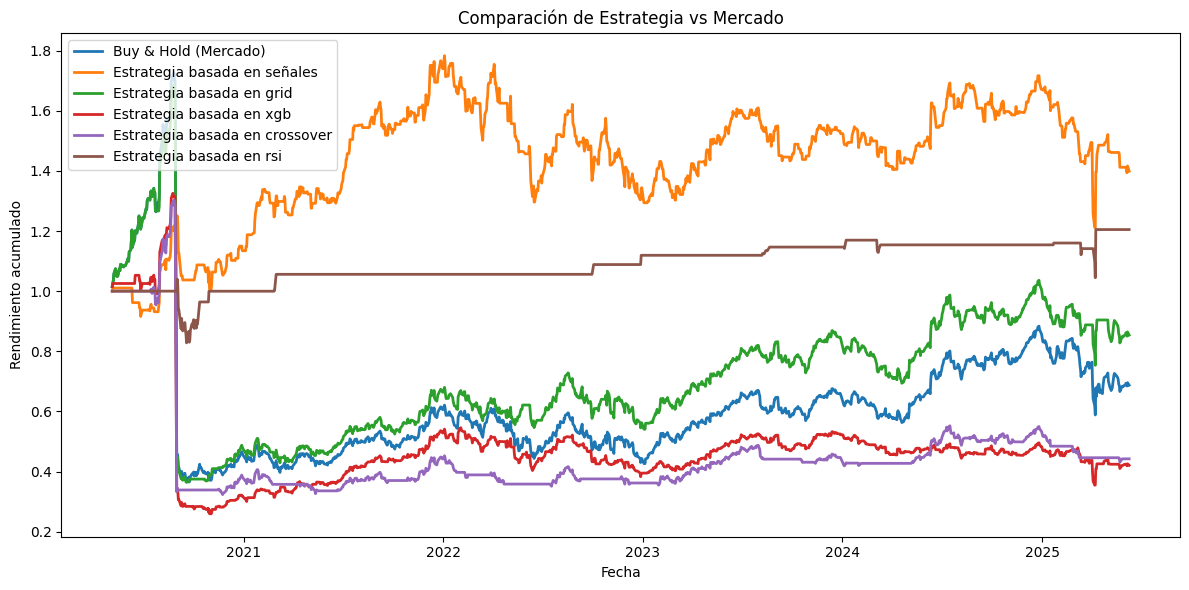

In [5]:
# Cell 5: Visualizar resultados
plt.figure(figsize=(12, 6))
plt.plot(signal_df['cumulative_market'], label="Buy & Hold (Mercado)", linewidth=2)
plt.plot(signal_df['cumulative_strategy'], label="Estrategia basada en señales", linewidth=2)
plt.plot(signal_df['cumulative_strategy_best'], label="Estrategia basada en grid", linewidth=2)
plt.plot(signal_df['cumulative_strategy_xgb'], label="Estrategia basada en xgb", linewidth=2)
plt.plot(signal_df['cumulative_strategy_crossover'], label="Estrategia basada en crossover", linewidth=2)
plt.plot(signal_df['cumulative_strategy_rsi'], label="Estrategia basada en rsi", linewidth=2)
plt.legend()
plt.title("Comparación de Estrategia vs Mercado")
plt.xlabel("Fecha")
plt.ylabel("Rendimiento acumulado")
plt.tight_layout()
plt.show()


In [6]:
# Cell 6: Métricas de rendimiento
def sharpe_ratio(series, risk_free_rate=0.0):
    return (series.mean() - risk_free_rate) / series.std() * np.sqrt(252)

def max_drawdown(cumulative_returns):
    roll_max = cumulative_returns.cummax()
    drawdown = cumulative_returns / roll_max - 1
    return drawdown.min()

strategy_returns = signal_df['strategy'].dropna()
strategy_best_returns = signal_df['strategy_best'].dropna()
strategy_xgb_returns = signal_df['strategy_xgb'].dropna()
strategy_rsi_returns = signal_df['strategy_rsi'].dropna()
strategy_crossover_returns = signal_df['strategy_crossover'].dropna()
market_returns = signal_df['returns'].dropna()

print("📊 Performance Metrics")
print(f"Sharpe Ratio (Estrategia): {sharpe_ratio(strategy_returns):.2f}")
print(f"Sharpe Ratio (Estrategia_best): {sharpe_ratio(strategy_best_returns):.2f}")
print(f"Sharpe Ratio (Estrategia_xgb): {sharpe_ratio(strategy_xgb_returns):.2f}")
print(f"Sharpe Ratio (Estrategia_crossover): {sharpe_ratio(strategy_crossover_returns):.2f}")
print(f"Sharpe Ratio (Estrategia_rsi): {sharpe_ratio(strategy_rsi_returns):.2f}")
print(f"Sharpe Ratio (Mercado):   {sharpe_ratio(market_returns):.2f}")
print(f"Max Drawdown (Estrategia): {max_drawdown(signal_df['cumulative_strategy']):.2%}")
print(f"Max Drawdown (Estrategia_best): {max_drawdown(signal_df['cumulative_strategy_best']):.2%}")
print(f"Max Drawdown (Estrategia_xgb): {max_drawdown(signal_df['cumulative_strategy_xgb']):.2%}")
print(f"Max Drawdown (Estrategia_crossover): {max_drawdown(signal_df['cumulative_strategy_crossover']):.2%}")
print(f"Max Drawdown (Estrategia_rsi): {max_drawdown(signal_df['cumulative_strategy_rsi']):.2%}")
print(f"Max Drawdown (Mercado):    {max_drawdown(signal_df['cumulative_market']):.2%}")


📊 Performance Metrics
Sharpe Ratio (Estrategia): 0.41
Sharpe Ratio (Estrategia_best): 0.29
Sharpe Ratio (Estrategia_xgb): -0.06
Sharpe Ratio (Estrategia_crossover): -0.06
Sharpe Ratio (Estrategia_rsi): 0.37
Sharpe Ratio (Mercado):   0.20
Max Drawdown (Estrategia): -32.07%
Max Drawdown (Estrategia_best): -78.34%
Max Drawdown (Estrategia_xgb): -80.44%
Max Drawdown (Estrategia_crossover): -75.20%
Max Drawdown (Estrategia_rsi): -20.38%
Max Drawdown (Mercado):    -78.89%


In [7]:
# En el notebook de entrenamiento
signal_df.to_csv('/workspaces/backtesting/investment-portfolio-project/data/signal.csv', index=False)
